In [1]:
from symred.build_model import build_molecule_for_projection
from symred.utils import exact_gs_energy, quasi_model
from quantumtools import VariationalAlgorithm
import json
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from itertools import combinations, product
import openfermion as of
import openfermionpyscf as ofpyscf
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HO

# Build the molecule and CS-VQE model

In [3]:
# Set molecule parameters
speciesname = 'HF_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)
model = build_molecule_for_projection(calculated_molecule, basis_weighting='ham_coeff')

------------------------------------------------
Information concerning the full system:
------------------------------------------------
Number of qubits in full problem: 12
The Hartree-Fock state is |111111111100>
HF   energy = -98.57101107
MP2  energy = -98.59198166
CISD energy = -98.60330178
CCSD energy = -98.60330177
FCI energy  = -98.60330178
------------------------------------------------
Tapering information:
------------------------------------------------
We are able to taper 4 qubits from the Hamiltonian
The symmetry sector is:
-1 ZIZIZIIZIZZI +
-1 IZIZIZIZIZIZ +
1 IIIIIIZZIIII +
1 IIIIIIIIZZII
The tapered Hartree-Fock state is |11111100>
------------------------------------------------
CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -98.83219906598114
Symmetry generators:    
1 IIIIIIIZ +
-1 IIIIIZII +
-1 IIIIZIII +
-1 IIIZIIIZ +
-1 IIZIIIZI +
1 IZIZZZIZ +
1 ZIZIZZZI
Clique representatives: 
-0.5483376293 IIZIIIII +
-0.83625704

In [4]:
num_sim_q = 4
stab_indices = model.greedy_search(num_sim_q)
projected = model.contextual_subspace_projection(stab_indices)
nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
error = abs(nrg-model.fci_energy)
print(f'{projected.n_qubits}-qubit CS-VQE error: {error: .6f} | stabilizer indices: {stab_indices}')

1-qubit CS-VQE error:  0.032291
2-qubit CS-VQE error:  0.006812
3-qubit CS-VQE error:  0.004705
4-qubit CS-VQE error:  0.000809
------ done ------
4-qubit CS-VQE error:  0.000809 | stabilizer indices: [2, 3, 6, 7]


# Run a VQE simulation over the contextual subspace

In [5]:
ham_cs = model.contextual_subspace_projection(stab_indices)
ucc_cs = model.contextual_subspace_projection(stab_indices, aux_operator=model.ucc_tap)
ref_cs = model.hf_tapered[model.free_qubit_indices]

vqe = VariationalAlgorithm(ham_cs, ucc_cs, ref_cs)

In [6]:
opt_out, interim = vqe.VQE(optimizer='SLSQP', exact=True, maxiter=10)#, n_shots=2**16, n_realize=1)
opt_out['fun'] - model.fci_energy

0.004755370745428422

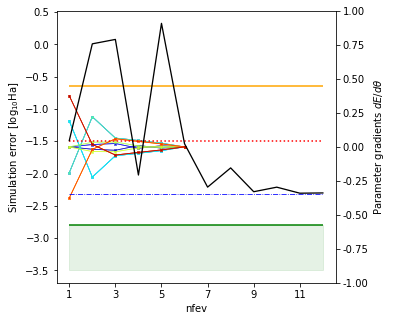

In [7]:
from matplotlib.ticker import FormatStrFormatter

fig,axis = plt.subplots(figsize = (5,5))#, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
#fig.tight_layout()

def transform(dataset, ref_val=0):
    return np.log10(abs(dataset-ref_val))

truegs = model.fci_energy
target = transform(opt_out['fun'], truegs)

Y = np.array(interim['values'])
Y_error = transform(Y, truegs)
Y_max = np.max(Y_error)+0.5
try:
    X_max = np.where(Y_error<np.log10(0.0016))[0][5]        
except:
    X_max = len(interim['gradients'])
X_max = len(Y_error)
X = np.arange(1, X_max)#len(cs_vqe_data['values'])+1)

nfev      = X[-1]
noncon    = transform(model.noncontextual_energy, truegs)
hf_energy = transform(model.hf_energy, truegs)
chemacc   = transform(0.0016)
axis.plot(X, transform(Y, truegs)[X-1], label='CS-VQE convergence', color='black', zorder=4, lw=1.3)

axis.hlines(hf_energy, 1, nfev, color='red',ls=':',label='Hartree-Fock energy', zorder=3)
axis.hlines(noncon, 1, nfev, color='orange', label='Noncontextual energy', zorder=2)
axis.hlines(chemacc, 1, nfev, color='green', label='Chemical accuracy', zorder=2)
axis.hlines(target, 1, nfev, color='blue', label='Optimal value', ls='-.', lw=0.8, zorder=3)

axis.fill_between(X, -3.5,np.log10(0.0016), color='green', alpha=0.1, zorder=1)
axis.fill_between(X, np.log10(0.0016), np.log10(model.noncontextual_energy- truegs), color='orange', alpha=0.1, zorder=1)
axis.fill_between(X, np.log10(model.noncontextual_energy- truegs),Y_max, color='red', alpha=0.1, zorder=1)

axis.set_xlabel('nfev')#, fontname=font)    
axis.set_ylabel('Simulation error [$\mathrm{log}_{10}\mathrm{Ha}$]', fontsize=10)#,fontname = font)
axis.set_xticks(np.arange(1, X_max, 2))
axis.set_yticks(np.arange(-3.5, Y_max, 0.5))

#opt_value   = data["noiseless"]["opt_param"]
param_trace = interim['gradients']
#axis.text(0.7, 0.85, f'VQE convergence of\n{len(param_trace)}-parameter Ansatz',
#            horizontalalignment='center', verticalalignment='center',transform=axis.transAxes, size=10)

axis_param = axis.twinx()
for index, Y_param in enumerate(zip(*param_trace)):
    Y_param = np.array(Y_param)
    c = plt.cm.jet(index/(len(param_trace[0])))
    axis_param.plot(np.arange(1, len(Y_param)+1), Y_param, color=c, lw=0.8, alpha=0.7, marker='x', ms=2)

axis_param.set_ylabel('Parameter gradients $dE/d\\theta$', fontsize=10)#,fontname = font)
axis_param.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#final_param = list(zip(*param_trace.values()))[-1]
#offset = np.std(final_param)
axis_param.set_ylim(-1,1)
axis.set_zorder(axis_param.get_zorder()+1)
axis.set_frame_on(False)


In [55]:
#ansatz=[]
for t in range(1,6):
    trials = []
    for i in range(ucc_cs.n_terms):
        anz_op_list = [ucc_cs[i]]+ansatz
        anz_op = reduce(lambda x,y:x+y, anz_op_list)
        vqe = VariationalAlgorithm(ham_cs, anz_op, ref_cs)
        min_val, interim = vqe.VQE(init_params=anz_op.coeff_vec.imag, 
                                   optimizer='SLSQP', 
                                   maxiter=10, 
                                   exact=True)
        trials.append((anz_op, abs(min_val['fun']-model.fci_energy)))   
    best_term, best_error = sorted(trials, key=lambda x:x[1])[0]
    ansatz.append(best_term)
    ansatz_op = reduce(lambda x,y:x+y, ansatz)
    print(f'Best {ansatz_op.n_terms}-term Ansatz has an error of {best_error: .8f}:')
    print(ansatz_op)
    print()

Best 6-term Ansatz has an error of  0.01016076:
0.0000000000-0.0058415275j ZIIIYXZ +
0.0000000000-0.0566510687j ZZZYXIZ +
0.0000000000-0.0136424380j IIYZZII +
0.0000000000+0.0194517210j YIIIIXX +
0.0000000000+0.0029207637j YIIXIIX +
0.0000000000-0.3012408010j XIIXYII

Best 7-term Ansatz has an error of  0.00768277:
0.0000000000-0.0116830549j ZIIIYXZ +
0.0000000000-0.1133021374j ZZZYXIZ +
0.0000000000-0.0272848759j IIYZZII +
0.0000000000+0.0389034419j YIIIIXX +
-0.0000000000-0.0003650955j XIIZXYZ +
0.0000000000+0.0058415275j YIIXIIX +
0.0000000000-0.6024816020j XIIXYII

Best 8-term Ansatz has an error of  0.00504178:
0.0000000000-0.0233661099j ZIIIYXZ +
0.0000000000+0.0003650955j IIIXZZY +
0.0000000000-0.2266042749j ZZZYXIZ +
0.0000000000-0.0545697519j IIYZZII +
0.0000000000+0.0778068838j YIIIIXX +
0.0000000000-0.0007301909j XIIZXYZ +
0.0000000000+0.0116830549j YIIXIIX +
0.0000000000-1.2049632041j XIIXYII

Best 9-term Ansatz has an error of  0.00265137:
0.0000000000-0.0467322198j ZIIIYX

In [57]:
print(anz_op)

0.0000000000-0.0467322198j ZIIIYXZ +
0.0000000000+0.0007301909j IIIXZZY +
0.0000000000-0.4532085498j ZZZYXIZ +
0.0000000000-0.1091395037j IIYZZII +
0.0000000000-0.0136424380j IYIZZII +
0.0000000000+0.1556137677j YIIIIXX +
0.0000000000-0.0014603819j XIIZXYZ +
0.0000000000+0.0233661099j YIIXIIX +
0.0000000000-2.4099264082j XIIXYII +
0.0000000000-0.0005568532j YXIIIZZ
